# Etude Snorkel / Extration de partenariats d'entreprises
Pour ce projet, nous allons essayer d'extraire des relations de partenariats économiques entre des entreprises depuis des articles. <br/>
Le but étant de comprendre l'utilisation de snorkel.

Nous allons découper notre traitement dans 3 notebooks (chacun correspondant à une étape du pipeline `Snorkel` :
1. Preprocessing
2. Training
3. Evaluation

## Partie II: Génération et modélisation de "_noisy_" labels contenant du bruit

Dans ce notebook, nous allons écrire nos **fonctions de labelisation** pour étiquetter nos données.
Comme ces `Labeling functions` ne seront pas parfaites, nous allons modéliser leur précision avec un modèle _generative_ que `Snorkel` nous permettra d'appliquer.

Nous les utiliserons pour produire un ensemble de label pour nos données d'entrainement. Ces données bien que contenant du bruit, pourront ensuite être appliquer à un modèle de classification.

***

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import numpy as np
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.viewer import SentenceNgramViewer
from snorkel.lf_helpers import test_LF
from snorkel.annotations import load_gold_labels
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,get_text_splits,
    contains_token, rule_text_btw, rule_text_in_span
)

from lib.scoring import *
from lib.lf_factories import *

session = SnorkelSession()

# I. Préparation des données

## 1. Notre schéma

On initialise de nouveau notre relation de partenariat entre 2 entreprises

In [2]:
Partner = candidate_subclass('Partner', ['company1', 'company2'])

## 2. Chargement de notre jeu de données de _development_

Nous chargeons les données qui ont été labelisées manuellement et qui font parties de notre jeu de développement (split = 1)

In [3]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [4]:
L_gold_dev.shape

(271, 1)

## 3. Data exploration

Analysons nos données pour nous aider à créer les fonctions de labeling.

In [5]:
# load our list of training & development candidates
train_cands = session.query(Partner).filter(Partner.split == 0).all()
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()

SentenceNgramViewer(train_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[387]], [[198, 199, 200, 201, 202, 203, 1096, 1097, 1098, 1099, 1100, 1273, 1274, 1…

# II. Ecriture des fonctions de labelisation (`Labeling Function`)

`get_left_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_right_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_between_tokens(c, attrib='words', n_max=1, case_sensitive=False)
get_text_between(c)
get_tagged_text(c)
get_text_split(c)
contains_token`



### Métriques de nos Labeling Function

####  Coverage
C'est le nombre de candidats labelisés par notre LF sur un jeu de données (entrainement).

####  Precision / Recall / F1
Métriques standard pour les classification : précision, rappel, F1-score

In [6]:
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

## 1. Concurrences

In [7]:
# search between candidates, compet token for words like (competition, compete, competitive, ...)
def LF_compete(c):
    return -1 if re.search(r'compet', get_text_between(c), flags=re.I) else 0
   
labeled = coverage(session, LF_compete, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_compete, split=1, gold=L_gold_dev)

Coverage: 1.00% (33/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



In [8]:
competitors = {'competitor', 'competitors', 'competitive', 'competition', 'competitions' }
def LF_competitors(c):
    if len(competitors.intersection(get_right_tokens(c[1], window=40))) > 0 :
        return -1
    elif len(competitors.intersection(get_left_tokens(c[0], window=40))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_competitors, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_competitors, split=1, gold=L_gold_dev)

Coverage: 3.53% (117/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 11 | FN: 0



In [9]:
def LF_such_as(c) :
    return -1 if re.search(r'such as.{0,30}{{A}}.{0,30}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_such_as, split=0)
tp, fp, tn, fn = error_analysis(session, LF_such_as, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 2.05% (68/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 5 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [10]:
against = ['alternative(s)?', 'vs', 'rival(s)?', 'versus', 'surpass(es|ed)?' , 'competitor(s)?', 'leaders ']
def LF_against(c):
    return -1 if re.search(r'{{A}}.{0,50} ' + ltp(against) + '.{0,50}{{B}}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_against, split=0)
tp, fp, tn, fn = error_analysis(session, LF_against, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 0.90% (30/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 1 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [11]:
players = {'players', 'vendors', 'providers', 'provide','comparison', 'major', 'compare', 'compares'}
def LF_players(c) :
    if len(players.intersection(get_left_tokens(c[0], window=20))) > 0 :
        return -1 
    elif len(players.intersection(get_right_tokens(c[1], window=20))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_players, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_players, split=1, gold=L_gold_dev)

Coverage: 16.01% (531/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 37 | FN: 2



In [12]:
def LF_comas(c):
    return -1 if re.search(r'{{A}}.{0,3}\,.{0,3}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_comas, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_comas, split=1, gold=L_gold_dev)

Coverage: 6.63% (220/3316)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 13 | FN: 0



## 2. Acquisitions

In [13]:
acquisitions = ['acquir(e|ed|es|ing){1}', 'acquisition','purchase(s|d)?','buy(ing)?', 'bougth', 'parent'] 

def LG_acquisitions_between(c) :
    return -1 if re.search(r'{{A}}.{0,100} ' + ltp(acquisitions) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0
     
labeled = coverage(session, LG_acquisitions_between, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisitions_between, split=1, gold=L_gold_dev)

Coverage: 1.36% (45/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 5 | FN: 0



In [14]:
def LG_acquisition_before(c) :
    return -1 if 'acquisition' in (get_left_tokens(c[0], window=50, case_sensitive=False)) else 0

labeled = coverage(session, LG_acquisition_before, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisition_before, split=1, gold=L_gold_dev)

Coverage: 0.63% (21/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 3 | FN: 0



In [15]:
def LF_slash(c):
    return -1 if re.search(r'{{A}}.{0,3}/.{0,3}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_slash, split=0)
tp, fp, tn, fn = error_analysis(session, LF_slash, split=1, gold=L_gold_dev)

Coverage: 0.15% (5/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 3. Alias

In [16]:
# same company name
def LG_sameNames(c) :
    c1_name = c.company1.get_span()
    c2_name = c.company2.get_span()
    if c1_name == c2_name:
        return -1
    return 0

labeled = coverage(session, LG_sameNames, split=0)
tp, fp, tn, fn = error_analysis(session, LG_sameNames, split=1, gold=L_gold_dev)

Coverage: 12.03% (399/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 47 | FN: 0



In [17]:
def LG_contains(c) :
    c1_name = c.company1.get_span().lower()
    c2_name = c.company2.get_span().lower()
    return -1 if (c1_name in c2_name or c2_name in c1_name) else 0

    
labeled = coverage(session, LG_contains, split=0)
tp, fp, tn, fn = error_analysis(session, LG_contains, split=1, gold=L_gold_dev)

Coverage: 14.75% (489/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 52 | FN: 0



In [18]:
def LG_sigle(c):
    return -1 if re.search(r'{{A}}.{0,2}\({{B}}\)', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LG_sigle, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_sigle, split=1, gold=L_gold_dev)

Coverage: 0.33% (11/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



## 4. Partenariat

In [19]:
def LF_with_relations(c) :
    #return 1 if 'with' in get_text_between(c).lower().strip() else 0
    return 1 if re.search(r'{{A}}.{0,200}with.{0,200}{{B}}', get_tagged_text(c), re.I) else 0



def LF_with_relations_and_not_same(c) :
    return 1 if LF_with_relations(c) == 1 and LG_sameNames(c) != -1  else 0

labeled = coverage(session, LF_with_relations_and_not_same, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_with_relations_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(tp, session, n_per_page=1)

Coverage: 10.65% (353/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.735
Recall               1.0
F1                   0.847
----------------------------------------
TP: 25 | FP: 9 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0]], [[2, 3]], [[1]], [[13, 14, 15, 17, 18, 19, 20]], [[9]], [[8]], [[10]], [[11]]…

In [20]:
cooperations = ['partner(ed|s|ing)?', 'partnership(s)?','collaborat(e|es|ed|ion|ing){1}',
                'cooperat(e|es|ed|ion|ing){1}', 'associat(e|es|ed|ing|ion){1}',  'relationship(s)?',
                'work(s,|ed|ing)?'] 


def LF_cooperations_btw(c):
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(cooperations) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0

def LF_cooperations_btw_and_not_same(c) :
    return 1 if LF_cooperations_btw(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_cooperations_btw_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_cooperations_btw_and_not_same, split=1, gold=L_gold_dev)

Coverage: 6.97% (231/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.714
Recall               1.0
F1                   0.833
----------------------------------------
TP: 10 | FP: 4 | TN: 0 | FN: 0



In [21]:
relations = ['partner', 'collaborat','cooperat', 
             'associat',  'relation', 'join', 'alliance', 'unit', 'synergy', 'between'] 

def LF_relations_in_sentence(c) :
    return 1 if re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0


def LF_relations_in_sentence_and_not_same(c) :
    return 1 if LF_relations_in_sentence(c) == 1 and LG_sameNames(c) != -1  else 0


labeled = coverage(session, LF_relations_in_sentence_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_relations_in_sentence_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 34.62% (1148/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.84
Recall               1.0
F1                   0.913
----------------------------------------
TP: 21 | FP: 4 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[1]], [[0, 2, 3]]], html='<head>\n<style>\nspan.candidate {\n    background-color: …

In [22]:
def LF_alliances(c) :
    alliances = {'alliance', 'alliances', 'jointly', 'join', 'association', 'associations'}
    if len(alliances.intersection(get_left_tokens(c[0], window=50, case_sensitive=False))) > 0 :
        return 1
    elif len(alliances.intersection(get_right_tokens(c[1], window=50, case_sensitive=False))) > 0 :
        return 1
    else :
        return 0

    
def LF_alliances_and_not_same(c) :
    return 1 if LF_alliances(c) == 1 and LG_sameNames(c) != -1 else 0


labeled = coverage(session, LF_alliances_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_alliances_and_not_same, split=1, gold=L_gold_dev)

Coverage: 8.08% (268/3316)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 1 | FP: 0 | TN: 0 | FN: 0



In [23]:
def LF_and(c):
    return -1 if re.search(r'{{A}}.{0,5}and.{0,5}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_and, split=0)
tp, fp, tn, fn = error_analysis(session, LF_and, split=1, gold=L_gold_dev)

Coverage: 4.64% (154/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 11 | FN: 4



## 5. Procès

In [24]:
trials = [ ' su(ed|ing){1}', 'lawsuit(s)?', 'claim(s|ed)?', 'legal', 'jury', 'court(s)?',
          'patent(s)', 'violate(s|d)?', 'allege(s|d)?', 'law' ] 

def LF_trial_in_sentence(c) :
    return -1 if re.search(r''+ ltp(trials), get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_trial_in_sentence, split=0)
tp, fp, tn, fn = error_analysis(session, LF_trial_in_sentence, split=1, gold=L_gold_dev)

Coverage: 1.90% (63/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 14 | FN: 0



## 6. Clients

In [25]:
def LF_clients(c):
    clients = {'on', 'by', 'from', 'include'}
    return -1 if len(clients.intersection(get_left_tokens(c[1], window=3))) > 0 else 0


labeled = coverage(session, LF_clients, split=0)
tp, fp, tn, fn = error_analysis(session, LF_clients, split=1, gold=L_gold_dev)

Coverage: 5.88% (195/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 23 | FN: 2



In [26]:
def LF_or(c):
    return -1 if re.search(r'{{A}}.{0,8}or.{0,8}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_or, split=0)
tp, fp, tn, fn = error_analysis(session, LF_or, split=1, gold=L_gold_dev)

Coverage: 0.87% (29/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 4 | FN: 0



# III. Application de nos fonctions de labelisation

## 1. Préparation des fonctions

On regroupe toutes les fonctions dans une liste.

In [27]:
LFs = [
    LF_compete,
    LF_competitors,
    LF_against,
    LF_players,
    LG_acquisitions_between,
    LG_acquisition_before,
    LF_slash,
    LG_sameNames,
    LG_contains,
    LG_sigle,
    LF_with_relations_and_not_same,
    LF_cooperations_btw_and_not_same,
    LF_relations_in_sentence_and_not_same,
    LF_alliances_and_not_same,
    LF_and,
    LF_trial_in_sentence,
    LF_clients,
    LF_comas,
    LF_and,
    LF_such_as,
    LF_or
]

Ensuite nous appliquons nos LFs sur nos candidats d'entrainement afin de produire un ensemble de labels. 

In [28]:
labeler = LabelAnnotator(lfs=LFs)

## 2. Génération de la matrice de _labels_

In [29]:
%time L_train = labeler.apply(split=0, lfs=LFs, parallelism=1)
print("Train shape :", L_train.shape)

%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print("Dev shape :",L_dev.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 19.7 s, sys: 162 ms, total: 19.8 s
Wall time: 19.9 s
Train shape : (3316, 20)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2.96 s, sys: 115 ms, total: 3.08 s
Wall time: 3.13 s
Dev shape : (271, 20)


In [30]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_compete,0,0.009952,0.007539,0.004524
LF_competitors,1,0.035283,0.027744,0.004524
LF_against,2,0.009047,0.006634,0.003016
LF_players,3,0.160133,0.084439,0.034077
LG_acquisitions_between,4,0.013571,0.010555,0.005730
LG_acquisition_before,5,0.006333,0.006333,0.006031
LF_slash,6,0.001508,0.000905,0.000603
LG_sameNames,7,0.120326,0.120326,0.000000
LG_contains,8,0.147467,0.135706,0.012967
LG_sigle,9,0.003317,0.001809,0.000905


## 3. Label Matrix Empirical Accuracies

In [31]:
import warnings
warnings.filterwarnings("ignore")
L_dev.lf_stats(session, labels=L_gold_dev.toarray().ravel())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_compete,0,0.007380,0.007380,0.00000,0,0,0,2,1.000000
LF_competitors,1,0.040590,0.033210,0.00000,0,0,0,11,1.000000
LF_against,2,0.003690,0.000000,0.00000,0,0,0,1,1.000000
LF_players,3,0.143911,0.099631,0.01476,0,0,2,37,0.948718
LG_acquisitions_between,4,0.018450,0.003690,0.00000,0,0,0,5,1.000000
LG_acquisition_before,5,0.011070,0.011070,0.00000,0,0,0,3,1.000000
LF_slash,6,0.000000,0.000000,0.00000,0,0,0,0,NaN
LG_sameNames,7,0.173432,0.173432,0.00000,0,0,0,47,1.000000
LG_contains,8,0.191882,0.184502,0.00000,0,0,0,52,1.000000
LG_sigle,9,0.007380,0.000000,0.00000,0,0,0,2,1.000000


# IV. Entrainement du _generative_ modèle

## 1. Entrainement du modèle

In [32]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(L_train,  decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0)

Inferred cardinality: 2


## 2. Précision du modèle

In [33]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_compete,0,0.007380,0.007380,0.00000,0,0,0,2,1.000000,0.589365
LF_competitors,1,0.040590,0.033210,0.00000,0,0,0,11,1.000000,0.602433
LF_against,2,0.003690,0.000000,0.00000,0,0,0,1,1.000000,0.605841
LF_players,3,0.143911,0.099631,0.01476,0,0,2,37,0.948718,0.634822
LG_acquisitions_between,4,0.018450,0.003690,0.00000,0,0,0,5,1.000000,0.583695
LG_acquisition_before,5,0.011070,0.011070,0.00000,0,0,0,3,1.000000,0.591670
LF_slash,6,0.000000,0.000000,0.00000,0,0,0,0,NaN,0.584086
LG_sameNames,7,0.173432,0.173432,0.00000,0,0,0,47,1.000000,0.644678
LG_contains,8,0.191882,0.184502,0.00000,0,0,0,52,1.000000,0.650310
LG_sigle,9,0.007380,0.000000,0.00000,0,0,0,2,1.000000,0.594293


## 3. Probabilités marginales

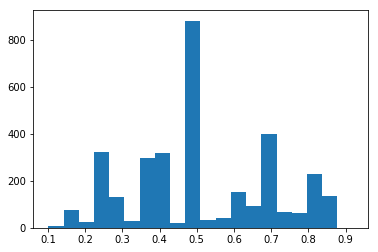

In [34]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [35]:
#train_marginals.shape
L_train.shape

(3316, 20)

In [36]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.593472,0.4504,0.594242,0.265101
1,0.614846,0.4715,0.613123,0.288782
2,0.595745,0.4606,0.591882,0.266305
3,0.621944,0.5031,0.625738,0.319085
4,0.591577,0.4559,0.587769,0.268112
5,0.595679,0.4536,0.587890,0.261088
6,0.592584,0.4531,0.593750,0.266907
7,0.651214,0.4983,0.653409,0.323099
8,0.651491,0.5030,0.644804,0.327514
9,0.594152,0.4583,0.600090,0.266506


In [37]:
dev_marginals = gen_model.marginals(L_dev)

In [38]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.633
Neg. class accuracy: 0.943
Precision            0.76
Recall               0.633
F1                   0.691
----------------------------------------
TP: 38 | FP: 12 | TN: 199 | FN: 22



In [39]:
SentenceNgramViewer(fp, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[4]], [[1]], [[2]], [[0, 7, 8]], [[3]], [[5, 6]], [[9, 10, 11]]], html='<head>\n<st…